<a href="https://colab.research.google.com/github/HelloShagun/EOWater/blob/main/Map_IGARSS_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
pip install earthengine-api geemap mss cartopy

In [4]:
import ee
import geemap

# 1. Initialize with your specific Project ID
project_id = 'ee-shagungargc2020'

try:
    ee.Initialize(project=project_id)
    print("Earth Engine initialized successfully!")
except Exception as e:
    ee.Authenticate()
    ee.Initialize(project=project_id)

# 2. Region of Interest: UK
countries = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017")
uk = countries.filter(ee.Filter.eq('country_na', 'United Kingdom'))
uk_geom = uk.geometry()

# 3. Sentinel-2 Mosaic Logic
def mask_clouds(image):
    scl = image.select('SCL')
    # Keeping vegetation, soils, and water; masking clouds and shadows
    mask = scl.neq(3).And(scl.neq(8)).And(scl.neq(9)).And(scl.neq(10)).And(scl.neq(11))
    return image.updateMask(mask).divide(10000)

s2_col = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
    .filterBounds(uk_geom) \
    .filterDate('2024-03-01', '2024-09-30') \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
    .map(mask_clouds)

s2_mosaic = s2_col.median().clip(uk_geom)


Earth Engine initialized successfully!


In [6]:


# 4. HydroLAKES Data
# Using the specific project path you provided
lakes = ee.FeatureCollection("projects/sat-io/open-datasets/HydroLakes/lake_poly_v10")
uk_lakes = lakes.filterBounds(uk_geom)

# 5. Visualization Setup
Map = geemap.Map(layout={'height': '800px', 'width': '100%'})
Map.centerObject(uk_geom, 6)

# Add the Satellite Background (B4, B3, B2 for True Color)
s2_vis = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3, 'gamma': 1.3}
Map.addLayer(s2_mosaic, s2_vis, 'Sentinel-2 Mosaic')

# Add Lakes with a Highlighted Color (Bright Blue/Cyan)
Map.addLayer(uk_lakes, {'color': '00FFFF'}, 'HydroLakes (Highlighted)')

# Add UK Boundary Outline
outline = ee.Image().byte().paint(featureCollection=uk, color=1, width=2)
Map.addLayer(outline, {'palette': 'black'}, 'UK Boundary')

# 6. Final Map Display
Map

Map(center=[54.02578252225892, -2.7797182104658], controls=(WidgetControl(options=['position', 'transparent_bg…

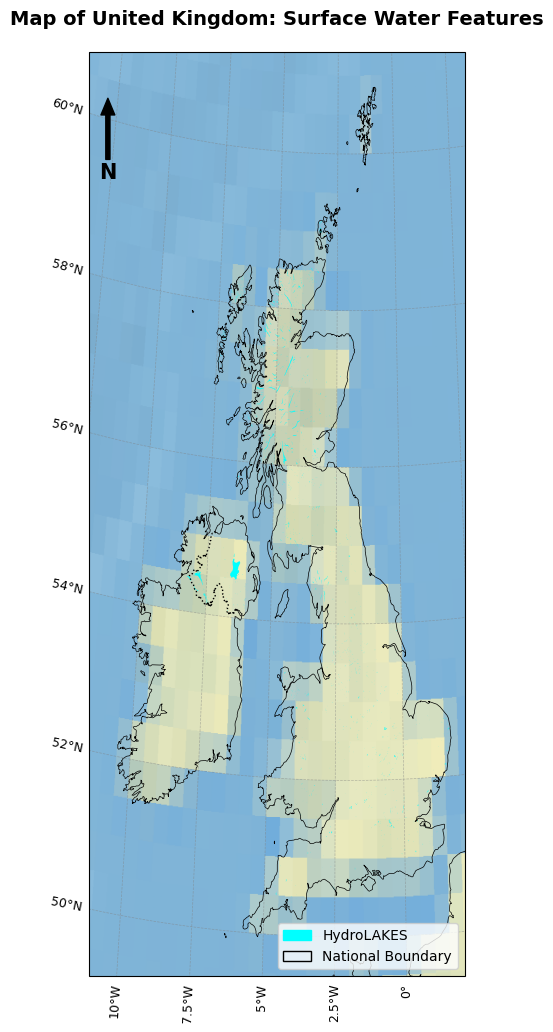

High-quality map saved to /content/UK_Hydro_Publication.png


In [7]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.patches as mpatches
import geemap

# 1. Convert GEE Lakes to a format Matplotlib can use (GeoPandas)
# This allows us to plot the specific data you found in GEE
print("Downloading lake data for plotting...")
uk_lakes_gdf = geemap.ee_to_gdf(uk_lakes)

# 2. Setup the figure
fig = plt.figure(figsize=(10, 12))
projection = ccrs.TransverseMercator(central_longitude=-2)
ax = plt.axes(projection=projection)
ax.set_extent([-11, 2, 49.5, 61], crs=ccrs.PlateCarree())

# 3. Add Professional Backgrounds
# stock_img() provides a clean, fast-rendering global satellite-style background
ax.stock_img()

# Add high-resolution borders and coastlines
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.5)
ax.add_feature(cfeature.BORDERS.with_scale('10m'), linestyle=':', linewidth=1)

# 4. Plot the HydroLAKES data
# We plot the GeoPandas dataframe directly onto the Cartopy axis
uk_lakes_gdf.plot(ax=ax, color='cyan', transform=ccrs.PlateCarree(), label='Lakes')

# 5. The "QGIS Frame": Gridlines and Labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 9, 'color': 'black'}
gl.ylabel_style = {'size': 9, 'color': 'black'}

# 6. Aesthetic Touches: Legend & North Arrow
lake_patch = mpatches.Patch(color='cyan', label='HydroLAKES')
border_patch = mpatches.Patch(edgecolor='black', facecolor='none', label='National Boundary')
plt.legend(handles=[lake_patch, border_patch], loc='lower right', frameon=True)

# Add a North Arrow
x, y, arrow_length = 0.05, 0.95, 0.08
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=3, headwidth=10),
            ha='center', va='center', fontsize=15, fontweight='bold',
            xycoords='axes fraction')

plt.title("Map of United Kingdom: Surface Water Features", pad=20, fontsize=14, fontweight='bold')

# 7. Save for Publication
output_path = '/content/UK_Hydro_Publication.png'
plt.savefig(output_path, bbox_inches='tight', dpi=300)
plt.show()

print(f"High-quality map saved to {output_path}")

Processing spatial data... this ensures the UK isn't stretched.


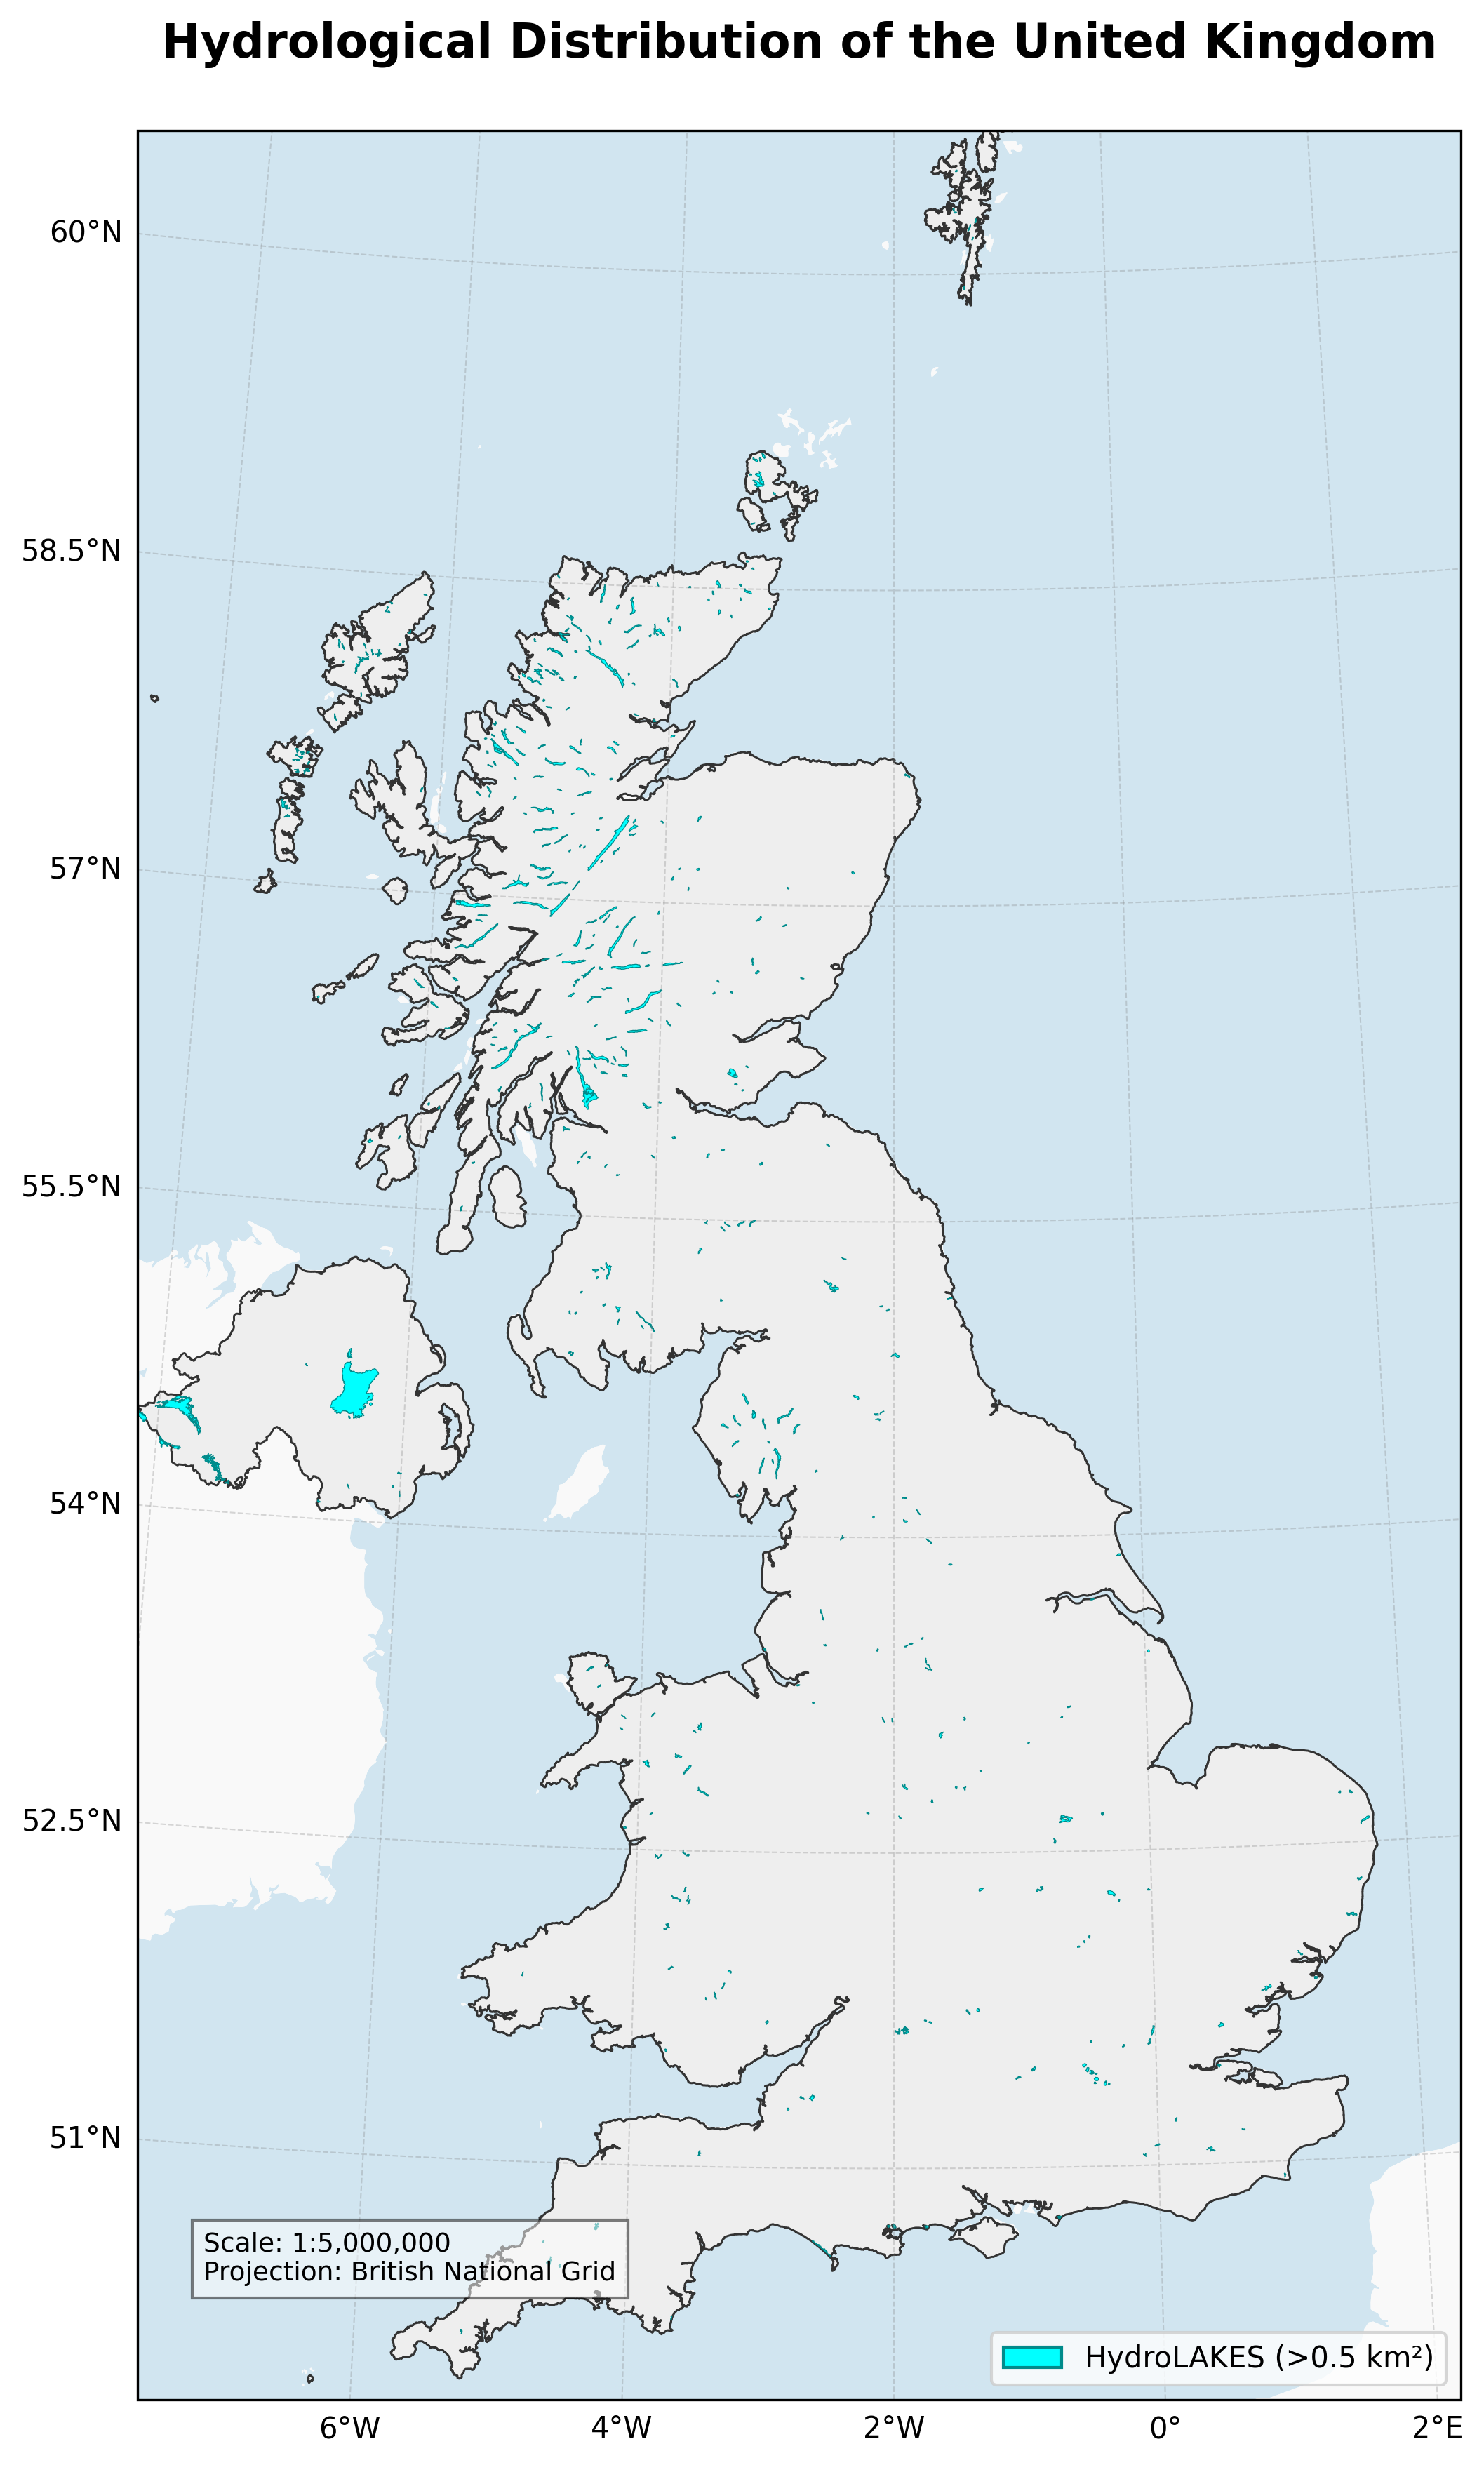

In [8]:
# 2. Data Prep
countries = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017")
uk = countries.filter(ee.Filter.eq('country_na', 'United Kingdom'))
lakes = ee.FeatureCollection("projects/sat-io/open-datasets/HydroLakes/lake_poly_v10")

# Optimization: Filter for larger lakes so they are visible on a national map
# Only lakes > 0.5 sq km to reduce clutter and processing time
uk_lakes = lakes.filterBounds(uk.geometry()).filter(ee.Filter.gt('Lake_area', 0.5))

print("Processing spatial data... this ensures the UK isn't stretched.")
uk_lakes_gdf = geemap.ee_to_gdf(uk_lakes)
uk_border_gdf = geemap.ee_to_gdf(uk)

# 3. Setup the Figure with the CORRECT Projection (British National Grid)
# This prevents the 'stretched' look.
fig = plt.figure(figsize=(10, 14), dpi=300)
ax = plt.axes(projection=ccrs.OSGB(approx=False))

# Focus specifically on the UK area
ax.set_extent([-9, 2.5, 49.8, 60.5], crs=ccrs.PlateCarree())

# 4. Layers
# Clean background for better contrast
ax.add_feature(cfeature.OCEAN.with_scale('10m'), facecolor='#d1e5f0')
ax.add_feature(cfeature.LAND.with_scale('10m'), facecolor='#f9f9f9', edgecolor='none')

# Plot the UK Border with a clean, thin line
uk_border_gdf.to_crs(epsg=27700).plot(ax=ax, facecolor='#eeeeee', edgecolor='#333333', linewidth=0.7)

# PLOT LAKES ON TOP - Using Cyan with a thin blue edge to make them "pop"
uk_lakes_gdf.to_crs(epsg=27700).plot(
    ax=ax,
    color='#00ffff',
    edgecolor='#008b8b',
    linewidth=0.3,
    label='HydroLAKES'
)

# 5. Professional Grids
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=0.5, color='gray', alpha=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# 6. Title and Legend
plt.title("Hydrological Distribution of the United Kingdom", fontsize=16, fontweight='bold', pad=25)

# Scale Bar (Manual)
ax.text(0.05, 0.05, 'Scale: 1:5,000,000\nProjection: British National Grid',
        transform=ax.transAxes, fontsize=9, verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.5))

# Legend
lake_patch = mpatches.Patch(color='#00ffff', ec='#008b8b', label='HydroLAKES (>0.5 km²)')
plt.legend(handles=[lake_patch], loc='lower right', frameon=True, fontsize=10)

# 7. Final Export
output_path = '/content/UK_Final_Map_Professional.png'
plt.savefig(output_path, bbox_inches='tight', pad_inches=0.2)
plt.show()